# goal: modeling outcome variables

## modeling strategy

Based on the results of the processing and exploration, I engineered features and built models to evaluate their performance. The model training strategy is as follows:
- split the data between 2018 and 2019
- tune the model on 2018 data by hyperparameter search and cross-validation, evaluating results on out-of-sample performance
- evaluate selected models for each type of algorithm on 2019 data to determine best model

In [146]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import contextily as ctx

import itertools
from functools import partial
from sklearn.linear_model import PoissonRegressor, LinearRegression
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from scipy.stats import randint, uniform

In [2]:
data = pd.read_parquet('../data/processed_data.parquet')

In [3]:
data.head()

,station,date,hour,arrivals,departures,start_ind,name,capacity,latitude,longitude,prcp,snow,tavg,tmax,tmin,holiday
0,0,2019-11-30,8,1.0,0.0,False,22nd & H St NW,17,38.898925,-77.048852,0.0,0.0,6.3,7.8,5.0,0
1,0,2019-11-30,16,1.0,0.0,False,22nd & H St NW,17,38.898925,-77.048852,0.0,0.0,6.3,7.8,5.0,0
2,0,2019-11-30,19,1.0,0.0,False,22nd & H St NW,17,38.898925,-77.048852,0.0,0.0,6.3,7.8,5.0,0
3,0,2019-12-01,8,1.0,0.0,False,22nd & H St NW,17,38.898925,-77.048852,12.7,0.0,5.9,7.8,4.4,0
4,0,2019-12-01,13,1.0,0.0,False,22nd & H St NW,17,38.898925,-77.048852,12.7,0.0,5.9,7.8,4.4,0


In [4]:
station_data = data.loc[:,['station', 'name', 'capacity', 'latitude', 'longitude']].drop_duplicates(ignore_index=True)

In [5]:
initial_model_columns = ['station', 'date', 'hour', 'arrivals', 'departures', 'prcp', 'snow', 'tavg', 'tmax', 'tmin', 'holiday']
data = data.loc[:,initial_model_columns]

## defining variables
- temporal variables
- weather related indicator variables

In [6]:
## temporal variables
data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month
data['dow'] = data['date'].dt.day_of_week
data['is_weekend'] = (data['dow'] > 4).astype(int)
## weather indicators
data['is_prcp'] = (data['prcp'] > 0).astype(int)
data['is_snow'] = (data['snow'] > 0).astype(int)
## categorical indicators
data["station"] = data["station"].astype("category")
## removing extra variable
data.pop('date')

0         2019-11-30
1         2019-11-30
2         2019-11-30
3         2019-12-01
4         2019-12-01
             ...    
3211608   2019-12-24
3211609   2019-12-26
3211610   2019-12-28
3211611   2019-12-28
3211612   2019-12-30
Name: date, Length: 3211613, dtype: datetime64[ns]

### filtering down number of stations
To avoid potential sample size issues when evaluating the model at the station level, I filtered down the data to only include stations that have at least 60 observations in every month from 2018 to 2019. This allows me to make sure that each of the models trained have sufficient data at the station and time level to approximate the relationships in the data.

In [7]:
## filtering down to only stations with sufficient sample size across the data
stations_to_keep = data.groupby(['station', 'year', 'month'], as_index=False).size().query('size>=60').groupby('station', as_index=False).size().query('size==24')['station'].to_list()
print(data.shape[0])
data = data.loc[data['station'].isin(stations_to_keep), :]
print(data.shape[0])
data['arrivals'] = data['arrivals'].astype(int)
data['departures'] = data['departures'].astype(int)

3211613
2868026


## splitting the data
I split the data into 2018 and 2019 and then perform a stratified split at the station level to ensure there is enough observations for each station in both the testing and training data. Given the sample size, I split the stratified training data 50-50. I also apply geometric transformations to the cyclical date/time variables for improved interpretability by the models.

In [8]:
## using 2018 to predict 2019
X_2018 = data.copy().query('year==2018').drop(columns=['year']).reset_index(drop=True)
y_2018 = pd.concat([X_2018.pop('arrivals'), X_2018.pop('departures')], axis=1)
X_2019 = data.copy().query('year==2019').drop(columns=['year']).reset_index(drop=True)
y_2019 = pd.concat([X_2019.pop('arrivals'), X_2019.pop('departures')], axis=1)

In [9]:
def get_train_test_split(X, y, strata_columns, test_frac=0.5, seed=0):
    X.reset_index(inplace=True, drop=True)
    y.reset_index(inplace=True, drop=True)

    print('stratifying data...')
    def get_stratified_train_test_idx(data, strata_columns, test_frac=0.5, seed=0):
        np.random.seed(seed)
        train_idx, test_idx = [], []
        for r in data[strata_columns].drop_duplicates(ignore_index=True).itertuples():
            filter_string = ' and '.join(f'{c}=={getattr(r,c)}' for c in strata_columns) ## get subset of data
            filter_index = list(data.query(filter_string).index)
            slice_split = int(len(filter_index) * (1-test_frac)) + 1
            np.random.shuffle(filter_index) ## randomize
            train_idx.extend(filter_index[:slice_split])
            test_idx.extend(filter_index[slice_split:])
        return dict(train=train_idx, test=test_idx)
    idx_dict = get_stratified_train_test_idx(X, strata_columns, test_frac, seed)

    print('splitting data into test and train...')
    X_train = X.loc[X.index.isin(idx_dict['train'])].copy()
    X_test = X.loc[X.index.isin(idx_dict['test'])].copy()
    y_train = y.loc[y.index.isin(idx_dict['train'])].copy()
    y_test = y.loc[y.index.isin(idx_dict['test'])].copy()
    
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_train_test_split(X_2018, y_2018,['station', 'month'])

stratifying data...


C:\Users\Owner\AppData\Local\Temp\ipykernel_17884\2472934040.py:11: RuntimeWarning: Engine has switched to 'python' because numexpr does not support extension array dtypes. Please set your engine to python manually.
  filter_index = list(data.query(filter_string).index)


splitting data into test and train...


In [10]:
def apply_trigonometric_transformations(df):
    """
    Applies sine and cosine transformations to 'hour', 'month', and 'dow' columns in the dataframe.
    """
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    df['dow_sin'] = np.sin(2 * np.pi * df['dow'] / 7)
    df['dow_cos'] = np.cos(2 * np.pi * df['dow'] / 7)
    
    return df
X_train = apply_trigonometric_transformations(X_train)
X_test = apply_trigonometric_transformations(X_test)
X_2019 = apply_trigonometric_transformations(X_2019)

### linear models
I use stepwise variable selection to select the optimal combination of features on the training data, also using cross-validation to ensure that the results are generalizable. I train both the linear and poisson linear regression models and compare their performance, selecting the models that minimize out-of-sample error on the validation set.

In [53]:
def get_new_features_list(features_list):
    new_features_list = features_list.copy()
    old_features = ['hour', 'month', 'dow']
    new_features = ['hour_sin', 'hour_cos', 'month_sin', 'month_cos', 'dow_sin', 'dow_cos']
    for f in old_features:
        new_features_list.pop(new_features_list.index(f))
    for f in new_features:
        new_features_list.append(f)
    return new_features_list

def stepwise_regression_base(
        X_train,
        X_test,
        y_train,
        y_test,
        features_list,
        label,
        model_name,
        trig=False,
        seed=42  
):
    y_train_selected = y_train[label]
    y_test_selected = y_test[label]

    if trig:
        features_list = get_new_features_list(features_list)
    
    model_dict = {'linear' : LinearRegression(), 'poisson' : PoissonRegressor()}

    model = model_dict[model_name]

    sfs = SequentialFeatureSelector(model, n_features_to_select='auto', direction='forward', cv=3, n_jobs=-1)

    sfs.fit(X_train[features_list], y_train_selected)

    selected_features = sfs.get_feature_names_out()

    X_train_selected = X_train[selected_features]
    X_test_selected = X_test[selected_features]

    if model_name == 'linear':
        model.fit(X_train_selected, y_train_selected)
    else:
        param_grid = {'alpha': np.logspace(-5, 2, 100)} 
        model = RandomizedSearchCV(model, param_distributions=param_grid, cv=3, n_iter=50, random_state=seed)
        model.fit(X_train_selected, y_train_selected)

    y_pred = model.predict(X_test_selected)
    rmse = np.sqrt(mean_squared_error(y_test_selected, y_pred))
    return dict(model=model, features=selected_features, rmse=rmse, model_name=model_name, label=label)

stepwise_regression = partial(stepwise_regression_base, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test)

In [11]:
columns_no_inds = ['station','month', 'dow', 'hour', 'prcp', 'snow', 'tavg', 'tmax', 'tmin', 'holiday']
columns_inds = ['station', 'month', 'dow', 'is_weekend', 'hour', 'is_prcp', 'is_snow', 'tavg', 'tmax', 'tmin', 'holiday']

In [98]:
regression_results = []
i = 1
for trig, cols, label, model_name in itertools.product(
        (True, False),
        (columns_inds, columns_no_inds),
        ('arrivals', 'departures'),
        ('linear', 'poisson')
    ):  
    print(f'Beginning iteration {i}...\n')
    result = stepwise_regression(features_list=cols,label=label,model_name=model_name, trig=trig)
    regression_results.append(result)
    print('\nRun completed\n')
    i += 1

Beginning iteration 1...


Run completed

Beginning iteration 2...



c:\Users\Owner\anaconda3\Lib\site-packages\sklearn\linear_model\_glm\glm.py:282: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
c:\Users\Owner\anaconda3\Lib\site-packages\sklearn\linear_model\_glm\glm.py:282: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
c:\Users\Owner\anaconda3\Lib\site-packages\sklearn\linear_model\_glm\glm.py:282: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale 


Run completed

Beginning iteration 3...


Run completed

Beginning iteration 4...



c:\Users\Owner\anaconda3\Lib\site-packages\sklearn\linear_model\_glm\glm.py:282: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
c:\Users\Owner\anaconda3\Lib\site-packages\sklearn\linear_model\_glm\glm.py:282: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
c:\Users\Owner\anaconda3\Lib\site-packages\sklearn\linear_model\_glm\glm.py:282: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale 


Run completed

Beginning iteration 5...


Run completed

Beginning iteration 6...


Run completed

Beginning iteration 7...


Run completed

Beginning iteration 8...


Run completed

Beginning iteration 9...


Run completed

Beginning iteration 10...


Run completed

Beginning iteration 11...


Run completed

Beginning iteration 12...



c:\Users\Owner\anaconda3\Lib\site-packages\sklearn\linear_model\_glm\glm.py:282: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
c:\Users\Owner\anaconda3\Lib\site-packages\sklearn\linear_model\_glm\glm.py:282: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
c:\Users\Owner\anaconda3\Lib\site-packages\sklearn\linear_model\_linear_loss.py:290: RuntimeWarning: invalid value encountered in matmul
  grad[:n_features] = X.T @ grad_pointwise + l2_reg_strength * weights
c:\Users\Owner\anaconda3\Lib\s


Run completed

Beginning iteration 13...


Run completed

Beginning iteration 14...


Run completed

Beginning iteration 15...


Run completed

Beginning iteration 16...


Run completed



In [99]:
final_model_list = []
for label in ('arrivals', 'departures'):
    result = min((m for m in regression_results if m['label'] == label), key=lambda d: d['rmse'])
    final_model_list.append(result)

### Machine learning algorithms

In addition to training the linear models, I also build a pipeline to evaluate 3 different ML algorithms and use predictive modeling best practices to tune and select the optimal combination of hyperparameters via cross-validation and random search.

In [21]:
X_train['station'] = X_train['station'].cat.codes
X_test['station'] = X_test['station'].cat.codes

In [27]:
# Models other than linear regression
pipelines = {
    'random_forest': Pipeline([('model', RandomForestRegressor())]),
    'gradient_boosting': Pipeline([('model', GradientBoostingRegressor())]),
    'xgboost': Pipeline([('model', XGBRegressor())]),
}

param_grids = {
    'random_forest': {
        'model__n_estimators': randint(5, 50),
        'model__max_depth': randint(3, 6)
    },
    'gradient_boosting': {
        'model__n_estimators': randint(5, 50),
        'model__learning_rate': uniform(0.01, 0.3),
        'model__max_depth': randint(3, 6)
    },
    'xgboost': {
        'model__n_estimators': randint(5, 50),
        'model__learning_rate': uniform(0.01, 0.3),
        'model__max_depth': randint(3, 6)
    }
}

def evaluate_ml_model_base(
    X_train,
    X_test,
    y_train,
    y_test,
    pipeline,
    param_grid,
    label,
    seed=42
):
    search = RandomizedSearchCV(pipeline, param_grid, n_iter=10, scoring='neg_mean_squared_error', cv=3, random_state=seed, n_jobs=-1, verbose=2)
    search.fit(X_train, y_train[label])
    best_model = search.best_estimator_
    y_pred = best_model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test[label], y_pred))
    return dict(model=best_model, rmse=rmse, label=label)

evaluate_ml_model = partial(evaluate_ml_model_base, X_train, X_test, y_train, y_test)

In [ ]:
ml_results = []
i = 1
for label, (name, pipeline) in itertools.product(
        ('arrivals', 'departures'),
        pipelines.items()
    ):
    print(f'Beginning iteration {i}...\n')
    result = evaluate_ml_model(pipeline=pipeline, param_grid=param_grids[name], label=label)
    result['model_name'] = name
    ml_results.append(result)
    print('\nRun completed\n')
    i += 1

In [100]:
final_model_list.extend(ml_results)

### Test data evaluation

After training all my models and optimizing them on the training data, I evaluate them on the testing data from 2019 and choose the best performing model. For both arrivals and departures, the XGBoost model is the top performer.

In [12]:
def get_predictions(model_list=final_model_list,X=X_2019,y=y_2019,labels=['arrivals','departures']):
    y_predictions = y.copy()
    prediction_errors_list = []
    for label in labels:
        y_label = y[label]
        label_models = [m for m in model_list if m['label'] == label]
        for m in label_models:
            if m['model_name'] in ('poisson', 'linear'):
                y_pred = m['model'].predict(X[m['features']])
            else:
                y_pred = m['model'].predict(X)
            y_predictions['_'.join((label, m['model_name'], 'pred'))] = y_pred
            y_predictions['_'.join((label, m['model_name'], 'error'))] = y_label - y_pred
            prediction_errors_list.append(
                dict(
                    label=label,
                    model_name=m['model_name'],
                    rmse=np.sqrt(mean_squared_error(y_label,y_pred))
                )
            )
    prediction_errors = pd.DataFrame(prediction_errors_list)
    return prediction_errors, y_predictions

In [13]:
prediction_errors, predictions_2019 = get_predictions()

In [14]:
prediction_errors ## we can see that the xgboost model appears to perform best overall, but we can also gauge performance based on specific stations

,label,model_name,rmse
0,arrivals,poisson,2.800622
1,arrivals,random_forest,2.813939
2,arrivals,gradient_boosting,2.967122
3,arrivals,xgboost,2.447391
4,departures,poisson,2.791924
5,departures,random_forest,3.081958
6,departures,gradient_boosting,2.976092
7,departures,xgboost,2.432620


### additional model exploration

To learn a bit more about the model performance, I also explore the XGBoost model's feature importances and performance at the station level.
- feature importances: arrivals and departures select roughly the same features for their importances, but station is more important for departures than for arrivals
- station level performance: the model tends to perform well on most stations in the data set, but appears to struggle more with stations in downtown Washington D.C.
    - this warrants further discussion with stakeholders and investigation to consider building a model specific stations that have different patterns than the remaining stations

In [122]:
## plotting feature importances
def get_feature_importances_df(label, model_list=final_model_list):
    model = min([m for m in model_list if m['label']==label], key=lambda m: m['rmse'])['model']
    fi_df = pd.DataFrame(
        dict(
            label=label,
            feature=model.named_steps['model'].feature_names_in_,
            feature_importances=model.named_steps['model'].feature_importances_
        )
    ).sort_values('feature_importances', ascending=False, ignore_index=True)
    return fi_df

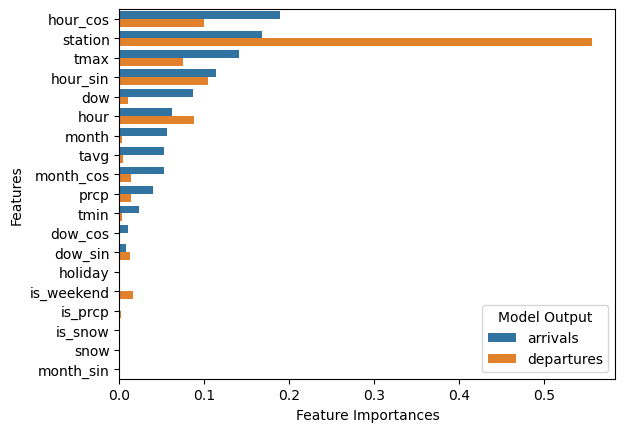

In [127]:
plot_df = pd.concat(
    [
        get_feature_importances_df('arrivals'),
        get_feature_importances_df('departures')
    ],
    axis=0
)
sns.barplot(
    data=plot_df,
    y='feature',
    x='feature_importances',
    hue='label'
)
plt.legend(title='Model Output', loc='lower right')
plt.xlabel('Feature Importances')
plt.ylabel('Features')
# plt.savefig('../results/model_feature_importances.png', bbox_inches='tight')
plt.show()

In [68]:
predictions_2019_final = predictions_2019.loc[:,['arrivals', 'arrivals_xgboost_pred', 'arrivals_xgboost_error', 'departures',  'departures_xgboost_pred', 'departures_xgboost_error']]
predictions_2019_final['arrivals_xgboost_error_sq'] = predictions_2019_final['arrivals_xgboost_error'] ** 2
predictions_2019_final['departures_xgboost_error_sq'] = predictions_2019_final['departures_xgboost_error'] ** 2

In [131]:
## combining all data
X_2019_original = X_2019.loc[:,['station', 'hour', 'prcp', 'snow', 'tavg', 'tmax', 'tmin', 'holiday', 'month', 'dow']]

In [132]:
combined_predictions = pd.concat([X_2019_original, predictions_2019_final], axis=1).merge(station_data, on='station', how='inner')

In [142]:
def rmse_across_dimension(
        group_cols,
        data=combined_predictions
):
    comparison_columns = ["departures_xgboost_error_sq", "arrivals_xgboost_error_sq"]
    rename_dict = dict(zip(comparison_columns, ['departures_xgboost_rmse', 'arrivals_xgboost_rmse']))
    comparison_df = data[comparison_columns]
    comparison_df = pd.concat([comparison_df, data.loc[:,group_cols]], axis=1)
    return np.sqrt(comparison_df.groupby(group_cols)[comparison_columns].mean().rename(columns=rename_dict)).reset_index()

In [144]:
group_cols = ['station', 'name', 'capacity', 'latitude', 'longitude']
rmse_df = rmse_across_dimension(group_cols)

<Axes: xlabel='RMSE', ylabel='Count'>

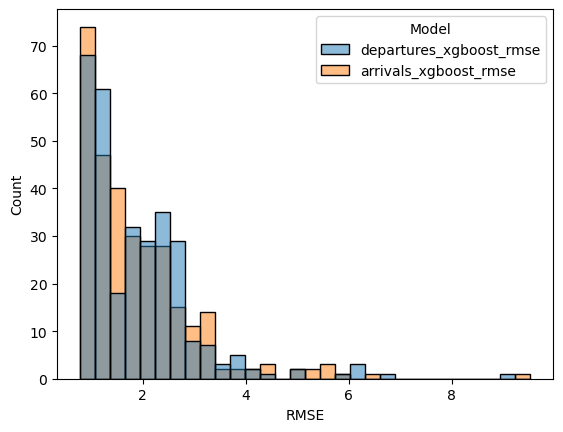

In [168]:
sns.histplot(
    data=rmse_df.melt(id_vars=['station'], value_vars=['departures_xgboost_rmse', 'arrivals_xgboost_rmse'], var_name='Model', value_name='RMSE'),
    x='RMSE',
    hue='Model',
    alpha=0.5
)

# rmse_df.melt(id_vars=['station'], value_vars=['departures_xgboost_rmse', 'arrivals_xgboost_rmse'])
# plt.savefig('../results/models_error_hist.png', bbox_inches='tight')
plt.show()

In [149]:
rmse_geo = gpd.GeoDataFrame(rmse_df, geometry=gpd.points_from_xy(rmse_df['longitude'], rmse_df['latitude']))
rmse_geo.set_crs('EPSG:4326', inplace=True)

,station,name,capacity,latitude,longitude,departures_xgboost_rmse,arrivals_xgboost_rmse,geometry
0,31002,Crystal Dr & 20th St S,17,38.856425,-77.049232,1.465455,1.429124,POINT (-77.04923 38.85642)
1,31003,Crystal Dr & 15th St S,16,38.861056,-77.049417,1.147650,1.105754,POINT (-77.04942 38.86106)
2,31004,Aurora Hills Cmty Ctr / 18th St & S Hayes St,12,38.857866,-77.059490,1.132406,1.086746,POINT (-77.05949 38.85787)
3,31005,Pentagon City Metro / 12th St & S Hayes St,19,38.862303,-77.059936,1.327760,1.268349,POINT (-77.05994 38.8623)
4,31007,Crystal City Metro / 18th St & S Bell St,19,38.857785,-77.051698,2.363482,2.013950,POINT (-77.0517 38.85778)
...,...,...,...,...,...,...,...,...
301,32045,Shady Grove Metro West,19,39.119765,-77.166093,0.844280,0.950958,POINT (-77.16609 39.11976)
302,32046,River Rd & Landy Ln,19,38.964992,-77.103381,1.081372,0.950301,POINT (-77.10338 38.96499)
303,32048,Bethesda Metro / Wisconsin Ave & Old Georgetow...,12,38.984691,-77.094537,0.959526,0.881475,POINT (-77.09454 38.98469)
304,32055,Woodmont Ave & Strathmore St,11,38.979875,-77.093522,0.996297,0.950611,POINT (-77.09352 38.97988)


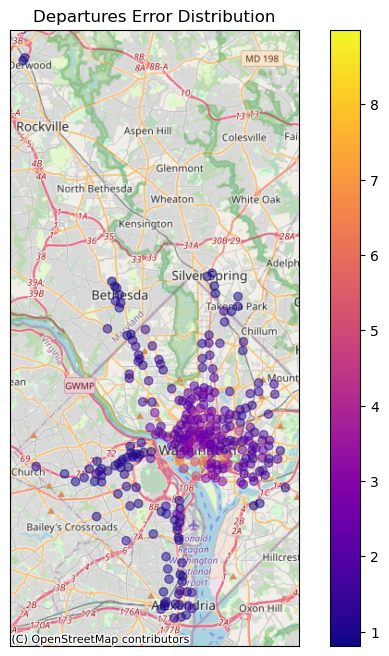

In [175]:
fig, ax = plt.subplots(figsize=(8,8))
rmse_geo.plot(
    ax=ax,
    column='departures_xgboost_rmse',
    marker='o',
    cmap='plasma',
    legend=True,
    alpha=0.5,
)
rmse_geo = rmse_geo.to_crs(epsg=3857)
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
ax.set_xticks([])
ax.set_yticks([])
plt.title('Departures Error Distribution')
# plt.savefig('../results/departures_error_geo.png', bbox_inches='tight')
plt.show()

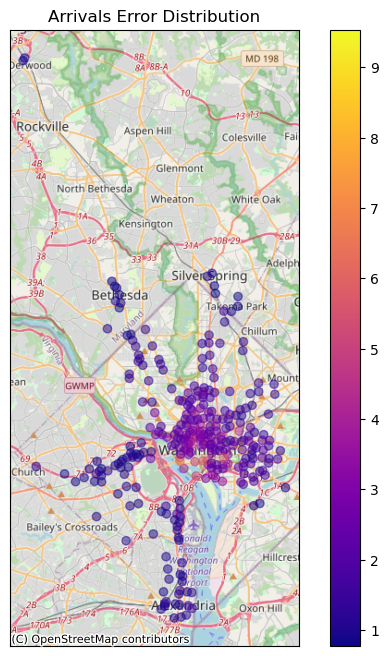

In [176]:
fig, ax = plt.subplots(figsize=(8,8))
rmse_geo.plot(
    ax=ax,
    column='arrivals_xgboost_rmse',
    marker='o',
    cmap='plasma',
    legend=True,
    alpha=0.5,
)
rmse_geo = rmse_geo.to_crs(epsg=3857)
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
ax.set_xticks([])
ax.set_yticks([])
plt.title('Arrivals Error Distribution')
# plt.savefig('../results/arrivals_error_geo.png', bbox_inches='tight')
plt.show()